# Classification (Bayesian) of the Palmer penguins data

This document is part of the showcase, where I replicate the same brief and simple analyses with different tools.

This particular file focuses on simple (Bayesian multiclass logit) classification of the Palmer penguins data from the tidytuesday project.

The data can be found in https://github.com/rfordatascience/tidytuesday/tree/master/data/2020/2020-07-28. They consist of one documents: penguins.csv contains information and measurements about some penguins.

For the specific analysis I will use Python and pymc3 (plus Jupyter notebook).

We start by loading the packages:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
The installed Theano(-PyMC) version (1.0.5) does not match the PyMC3 requirements.
It was imported from ['C:\\Users\\themi\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\theano']
For PyMC3 to work, a compatible Theano-PyMC backend version must be installed.
See https://github.com/pymc-devs/pymc3/wiki for installation instructions.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


and the dataset:

In [2]:
penguins = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-07-28/penguins.csv')

We can have a look at the schema of the data:

In [3]:
penguins.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
 7   year               344 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 21.6+ KB


and the summary statistics:

In [4]:
penguins.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
count,342.000000,342.000000,342.000000,342.000000,344.000000
mean,43.921930,17.151170,200.915205,4201.754386,2008.029070
std,5.459584,1.974793,14.061714,801.954536,0.818356
min,32.100000,13.100000,172.000000,2700.000000,2007.000000
25%,39.225000,15.600000,190.000000,3550.000000,2007.000000
50%,44.450000,17.300000,197.000000,4050.000000,2008.000000
75%,48.500000,18.700000,213.000000,4750.000000,2009.000000
max,59.600000,21.500000,231.000000,6300.000000,2009.000000


We start by checking for missing values:

In [5]:
penguins.isna().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
year                  0
dtype: int64

We drop all of them:

In [6]:
penguins = penguins.dropna(axis = 0, thresh=4, how = "all")
penguins.isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  9
year                 0
dtype: int64

For this analysis we are going to use only the numeric features, so we drop the categorical:

In [7]:
penguins = penguins.drop(columns=['year','island','sex'])

We are going to split the data into features and label:

In [8]:
species = penguins.pop('species')

Now we can split the dataset to training and testing:

In [9]:
X_train, X_test, y_train, y_test = train_test_split(penguins, species, test_size=0.2, random_state=1, stratify=species)

We extract the classes as a list:

In [10]:
classes = list(y_train.unique())
no_of_classes = len(classes)
no_of_classes

3

And we index them (this is useful for the pymc3 model):

In [11]:
y_train = y_train.apply(classes.index)
y_train

195    0
106    1
328    2
100    1
253    0
      ..
291    2
140    1
222    0
326    2
281    2
Name: species, Length: 273, dtype: int64

We also need to scale the features (We are going to use a standard Metropolis-Hastings MCMC and scaling would be useful)

In [12]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

We check the training data:

In [13]:
X_train

array([[ 1.07061905, -1.08701856,  1.09454738,  0.69118831],
       [-0.97354995,  0.01374581, -0.13901124, -0.563846  ],
       [ 0.34586822,  0.06378055, -0.57438487, -0.75210115],
       ...,
       [ 0.71753531, -1.08701856,  1.09454738,  0.69118831],
       [ 0.79186873, -0.38653214, -0.13901124, -1.09723559],
       [ 0.25295145,  0.31395427, -0.21157351, -0.31283914]])

Now we can specify and run the multi-logit model in pymc3:

In [14]:
with pm.Model() as model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sd=1, shape=no_of_classes)
    beta = pm.Normal('beta', mu=0, sd=1, shape=(X_train.shape[1], no_of_classes))
    
    # Likelihood
    mu = alpha + pm.math.dot(X_train, beta)
    p = pm.math.exp(mu)/pm.math.sum(pm.math.exp(mu), axis=0)
    
    y = pm.Categorical("y", p=p, observed=y_train)
    
    # Sampling
    step = pm.Metropolis()
    trace = pm.sample(1000, step=step)

C:\Users\themi\AppData\Local\Temp/ipykernel_8728/1960489258.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, step=step)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 142 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


We can plot the traces of the chains to check that they mixed properly:

C:\Users\themi\AppData\Local\Temp/ipykernel_8728/4255668653.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\themi\AppData\Local\Programs\Python\Python39\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

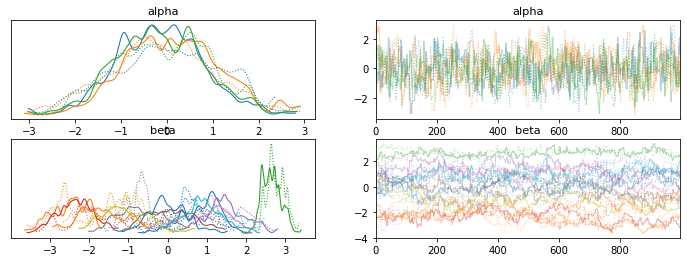

In [15]:
pm.traceplot(trace)

That looks decent.

In order to test on the testing data, we need to apply the same data pre-processing (i.e. scaling the features and indexing the label):

In [16]:
X_test = scaler.transform(X_test)

In [17]:
y_test = y_test.apply(classes.index)
y_test

58     1
297    2
337    2
51     1
26     1
      ..
295    2
130    1
176    0
14     1
325    2
Name: species, Length: 69, dtype: int64

For the purposes of this showcase project, we are going to use the MAP (maximum a posteriori estimate) for testing, which is effectively the mode of the posterior.

In [18]:
predictions = trace['alpha'].mean(axis=0) + np.dot(X_test, trace['beta'].mean(axis=0))
predicited_classes = np.argmax(np.exp(predictions).T / np.sum(np.exp(predictions), axis=1), axis=0)

We check the predicted classes:

In [19]:
predicited_classes

array([1, 2, 2, 1, 1, 2, 2, 0, 0, 1, 0, 2, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 2, 2, 1, 1, 1, 1, 0, 1, 1, 0, 2, 2, 1, 0, 0, 0, 2, 1, 0, 0, 0,
       0, 0, 1, 2, 1, 1, 0, 0, 1, 0, 0, 1, 2, 1, 0, 0, 1, 1, 1, 2, 2, 1,
       0, 1, 2], dtype=int64)

And finally the accuracy:

In [20]:
bayesianTestingAccuracy = accuracy_score(y_test, predicited_classes)
print("Accuracy: " + str(round(bayesianTestingAccuracy,4) * 100) + "%")

Accuracy: 98.55000000000001%
